In [94]:
import math
import json
import requests
import itertools
import numpy as np
import pandas as pd
import time
from datetime import datetime, timedelta
from dotenv import load_dotenv
import os
import json
import base64
import itertools
from tqdm.auto import tqdm
import pickle
import networkx as nx
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import community as community_louvain
import netwulf as nw
import random

# ALL CODE

In [95]:
load_dotenv()
client_id = os.getenv("CLIENT_ID")
client_secret = os.getenv("CLIENT_SECRET")

In [96]:
def get_token():
    auth_string = f"{client_id}:{client_secret}"
    auth_bytes = auth_string.encode("utf-8")
    auth_base64 = str(base64.b64encode(auth_bytes), "utf-8")

    url = "https://accounts.spotify.com/api/token"
    headers = {
        "Authorization": f"Basic {auth_base64}",
        "Content-Type": "application/x-www-form-urlencoded", 
        "limit": "50"
        }
    data = {
        "grant_type": "client_credentials"
    }
    result = requests.post(url, headers=headers, data=data)
    json_result = json.loads(result.content)
    token = json_result["access_token"]
    return token

def get_auth_header(token):
    return {"Authorization": f"Bearer {token}", "limit": "50"}

def search_for_artist(token, artist):
    url = "https://api.spotify.com/v1/search"
    headers = get_auth_header(token)
    query = f"?q={artist}&type=artist"
    query_url = url + query
    result = requests.get(query_url, headers=headers)
    if result.status_code != 200:
        print('Error: ', result.status_code)
    return result.json()

# Include genres in the query
def get_albums_by_artist(token, artist_id):
    url = f"https://api.spotify.com/v1/artists/{artist_id}/albums"
    headers = get_auth_header(token)
    query = f"?limit=50&"
    query_url = url + query
    result = requests.get(query_url, headers=headers)
    return result.json()

def get_tracks_by_album(token, album_id):
    url = f"https://api.spotify.com/v1/albums/{album_id}/tracks"
    headers = get_auth_header(token)
    query_url = url
    result = requests.get(query_url, headers=headers)
    return result.json()


# Use this for text analysis
def get_songs_by_artist(token, artist_id):
    url = f"https://api.spotify.com/v1/artists/{artist_id}/top-tracks"
    headers = get_auth_header(token)
    query = "?market=US"
    query_url = url + query
    result = requests.get(query_url, headers=headers, params={'genres': True})
    return result.json()


In [222]:
token = get_token()
response = search_for_artist(token, "Gucci Mane")
id1 = response["artists"]["items"][0]['id']
response["artists"]["items"][0]['genres']
id1
#get_albums_by_artist(token, id1)["items"][0].keys()#["genres"]


'13y7CgLHjMVRMDqxdx0Xdo'

In [98]:
def set_of_albums_by_artist(ALBUM_json):
    """
    Output: dict of unique album_names and album_ids
    Output example: {
        'Starboy (Deluxe)': '35dut3ICqF3NEDkjxfzJJ1',
        'Live At SoFi Stadium': '1OARrXe5sB0gyy3MhQ8h92', 
    """
    album_names = []
    album_ids = []
    for album in ALBUM_json['items']:
        if album['name'] not in album_names and album['album_type'] == 'album':
            album_names.append(album['name'])
            album_ids.append(album['id'])
    return dict(zip(album_names, album_ids))

# Example
#theWeeknd_albums = get_albums_by_artist(token, id1)
#set_of_albums_by_artist(theWeeknd_albums)

def features_from_album(ALBUM_json):
    """
    Output example: [
        ['Starboy (feat. Daft Punk)', [('Daft Punk', '4tZwfgrHOc3mvqYlEYSvVi')]],
        ['Party Monster', []],
        ...

    ]
    """
    feats_on_album = []
    for i in range(len(ALBUM_json['items'])):
        song_name = ALBUM_json['items'][i]['name']  

        all_features = []
        for features in ALBUM_json['items'][i]['artists']: #[1:]:
            all_features.append( (features['name'], features['id']) )

        feats_on_album.append(all_features)
        #feats_on_album.append([song_name, all_features])

    return feats_on_album

# Example
#starboy_json = get_tracks_by_album(token, WeekndAlbums[0][1])
#features_from_album(starboy_json)

## Make network



1. csv med artist-name
2. Få artist-id  **search_for_artist(token, artist)**
3. Få alle albums **get_albums_by_artist(token, artist)** --> **set_of_albums_by_artist(ALBUM_json)**
4. Få alle features **get_tracks_by_album(token, album_id)** --> **features_from_album(ALBUM_json)**

 1. Er det fair at bruge den liste om Top artists?
 2. ...

In [99]:
dfTopArtist = pd.read_csv('artists_charts.csv')
unique_artists = dfTopArtist['artist'].unique()
unique_artists

array(['Post Malone', 'Juice WRLD', 'Lil Uzi Vert', ...,
       'Das Sound Machine', 'Death Cab for Cutie', 'Purity Ring'],
      dtype=object)

In [74]:
len( unique_artists )

1250

Get raw data with all genres and features for an artist.

In [75]:
dict_genres = {}
dict_features = {}
for artist_name in tqdm(unique_artists[1114:]):
    response = search_for_artist(token, artist_name)
    artist_id = response["artists"]["items"][0]["id"]
    artist_genres = response["artists"]["items"][0]['genres']       # NEW 
    dict_genres[((artist_name,artist_id))] = {'all_genres': artist_genres}    # NEW

    artist_albums = get_albums_by_artist(token, artist_id)
    artist_albums_dict = set_of_albums_by_artist(artist_albums)

    all_features = []
    for album_name, album_id in artist_albums_dict.items():
        album_tracks = get_tracks_by_album(token, album_id)
        album_features = features_from_album(album_tracks)
        all_features.append(album_features)

    # Flatten and remove self
    flattened = list(itertools.chain(*itertools.chain(*all_features)))
    features_no_self = [feat for feat in flattened if feat != (artist_name, artist_id)]

    #dict_features[artist_name] = features_no_self
    # Should maybe have been
    dict_features[(artist_name,artist_id)] = features_no_self

  0%|          | 0/136 [00:00<?, ?it/s]

KeyboardInterrupt: 

Save the raw collected data:

In [90]:
#with open('dict_featuresALL.pickle', 'wb') as handle:
#    pickle.dump(dict_features, handle)

#with open('dict_genresALL.pickle', 'wb') as handle:
#    pickle.dump(dict_genres, handle)

### Might start here - Load the data again:

In [100]:
def read_files(input = False):
    if input:
        with open('dict_featuresALL.pickle', 'rb') as handle:
            dict_features = pickle.load(handle)

        with open('dict_genresALL.pickle', 'rb') as handle:
            dict_genres = pickle.load(handle)
        return dict_features, dict_genres
    else:
        pass
    
dict_features, dict_genres = read_files(True)

### Try get one genre

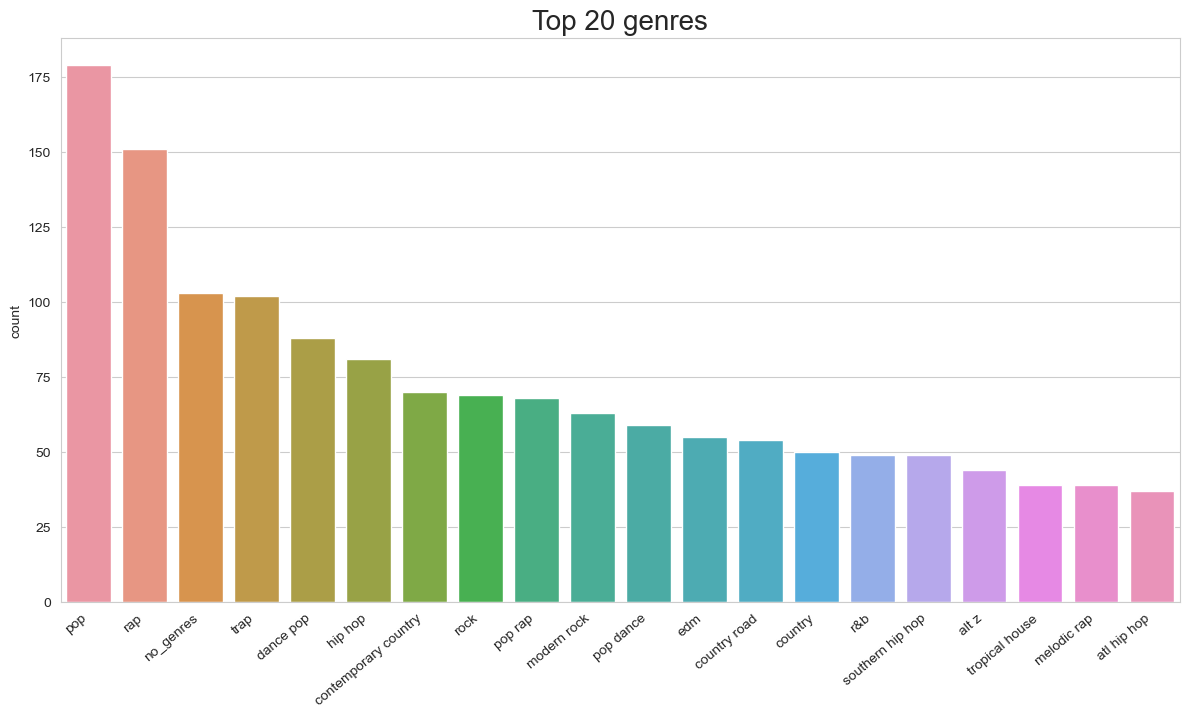

count     3623
unique     569
top        pop
freq       179
dtype: object

In [102]:
# Make histogram of number af times a genre is used for all artists
def make_hist_of_genres(dict_genres, key_to_use: str, top_n= 20):
    list_of_genres = []
    for dict in dict_genres.values():
        list_of_genres.append(dict[key_to_use])

    if key_to_use == 'all_genres':
        all_genres = list(itertools.chain(*list_of_genres))
        #all_genres = [genre for genre in all_genres if genre != '']
    else:
        all_genres = list_of_genres
    # Make the plot with seaborn
    sns.set_style("whitegrid")
    plt.figure(figsize=(12,7))
    ax = sns.countplot(x=all_genres, order=pd.value_counts(all_genres).iloc[:top_n].index)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
    plt.tight_layout()
    plt.title(f'Top {top_n} genres', fontsize=20)
    plt.show()
    return all_genres
    
all_genres = make_hist_of_genres(dict_genres, 'all_genres')
# print out general statistics for genres
df_all_genres = pd.Series(all_genres)
df_all_genres.describe()



The idea is getting one genre per artist such that: "dance pop" -> "pop". Thereby a majority vote can be made per artist.

In [109]:
considered_genres_ = ['rap', 'trap', 'pop', 'hip', 'hip-hop', 'r&b', 'rock', 'dance', 'edm', 'new', 'alt', 'electronic', 'country', 'latino', 'indie', 'alternative', 'metal', 'punk', 'jazz', 'blues', 'funk', 'soul', 'orchestra' , 'reggae', 'folk', 'disco', 'classical', 'gospel', 'world', 'christian', 'singer-songwriter', 'acoustic', 'instrumental', 'movie' ,'vocal', 'spoken', 'adult', 'comedy', 'soundtrack', 'musical', 'opera', 'afrofuturism', 'lounge', 'clubbing', 'ost', 'mellow' , 'cappella', 'stomp' , 'alt-z' , 'torch', 'sped', 'bass', 'easy', 'show', 'lo-fi', 'mexicana', 'broriginal-soundtrackep']
# hip is a one word representation of hip hop
considered_genres = list(set(all_genres + considered_genres_))
random.seed(12)

def get_top_genre(dict_genres):
    for i, ((artistname, artistid), dict_with_all_genres) in enumerate(dict_genres.items()):
        if dict_with_all_genres['all_genres'] != []:# and artistname == 'Ziv Zaifman':
            genres_single_words = list(itertools.chain(*[genre.split(' ') for genre in dict_with_all_genres['all_genres']]) )

            # Get frequency of each genre
            list_common = Counter(genres_single_words).most_common()
            highest_freq = Counter(genres_single_words).most_common(1)[0][1]
            # Get the genres with the highest frequency (shared first place)
            possible_top_genre = [genre for genre, freq in list_common if freq == highest_freq]
            # Remove genres that are not in the considered genres
            possible_top_genre = [genre for genre in possible_top_genre if genre in considered_genres]

            # Replace some genres with the same meaning
            possible_top_genre = list(map(lambda x: x.replace('hip', 'hip-hop'), possible_top_genre))
            possible_top_genre = list(map(lambda x: x.replace('new', 'new-age'), possible_top_genre))
            possible_top_genre = list(map(lambda x: x.replace('alt', 'alt-zentative'), possible_top_genre))
            possible_top_genre = list(map(lambda x: x.replace('alt-zentativeernative', 'alt-zentative'), possible_top_genre))
            possible_top_genre = list(map(lambda x: x.replace('ost', 'original-soundtrack'), possible_top_genre))
            possible_top_genre = list(map(lambda x: x.replace('show', 'original-soundtrack'), possible_top_genre))
            possible_top_genre = list(map(lambda x: x.replace('easy', 'easy-listening'), possible_top_genre))
            possible_top_genre = list(map(lambda x: x.replace('sped', 'sped-up'), possible_top_genre))
            possible_top_genre = list(map(lambda x: x.replace('cappella', 'a-cappella'), possible_top_genre))
            possible_top_genre = list(map(lambda x: x.replace('scandipop', 'pop'), possible_top_genre))



            # We have to choose now. Take the last value, since the order is always 1. hip-hip, 2. rap, 3. trap. 
            if possible_top_genre:
                print(artistname, possible_top_genre)
                random_top_genre = random.choice(possible_top_genre)
                print(random_top_genre)
                dict_genres[(artistname, artistid)]['top genre'] = random_top_genre
            
            # Check if the artist has a genre (not using split) that is in the considered genres and use that
            else:
                possible_top_genre = [genre for genre in genres_single_words if genre in considered_genres]
                dict_genres[(artistname, artistid)]['top genre'] = random.choice(possible_top_genre)

        else: # Not genres found
            dict_genres[(artistname, artistid)]['top genre'] = 'no_genres' # does not do anything
    return dict_genres

dict_genres_updated = get_top_genre(dict_genres)

list_of_artist_with_no_genre = [k for k,v in dict_genres_updated.items() if v['all_genres'] == ['no_genres']]
# Remove items from dict_genres where value of all_genres is 'no_genre'
dict_genres_updated = {k: v for k,v in dict_genres_updated.items() if v['all_genres'] != ['no_genres']}
# Remove items from dict_feature where with nodes with no genre
dict_features_updated = {}
for k,v in dict_features.items():
    if k not in list_of_artist_with_no_genre:
        # remove v elements which are in list_of_artist_with_no_genre
        dict_features_updated[k] = [artist for artist in v if artist not in list_of_artist_with_no_genre]


Post Malone ['rap']
rap
Juice WRLD ['rap']
rap
Lil Uzi Vert ['rap']
rap
J. Cole ['hip-hop']
hip-hop
Travis Scott ['hip-hop', 'rap', 'house']
rap
The Weeknd ['pop']
pop
XXXTENTACION ['emo', 'rap', 'hip-hop']
rap
Lil Baby ['trap']
trap
Kendrick Lamar ['hip-hop', 'rap']
rap
Glass Animals ['pop']
pop
Drake ['hip-hop', 'rap']
hip-hop
Roddy Ricch ['rap']
rap
The Neighbourhood ['rock']
rock
Offset ['hip-hop', 'rap', 'trap']
rap
The Kid LAROI ['hip-hop']
hip-hop
Olivia Rodrigo ['pop']
pop
Joji ['pop']
pop
Billie Eilish ['pop']
pop
Harry Styles ['pop']
pop
Morgan Wallen ['country']
country
Lewis Capaldi ['pop']
pop
The Chainsmokers ['electropop', 'pop', 'tropical', 'house']
tropical
Khalid ['pop']
pop
Childish Gambino ['hip-hop']
hip-hop
Dua Lipa ['pop']
pop
Doja Cat ['pop']
pop
DaBaby ['hip-hop']
hip-hop
Lil Nas X ['hip-hop', 'pop']
hip-hop
Lil Mosey ['rap']
rap
Ed Sheeran ['pop']
pop
Meek Mill ['hip-hop', 'rap']
hip-hop
Ariana Grande ['pop']
pop
Cardi B ['pop', 'rap']
pop
Halsey ['electropop'

In [112]:
#with open('dict_featuresPreProcessed.pickle', 'wb') as handle:
#    pickle.dump(dict_features_updated, handle)

#with open('dict_genresPreProcessed.pickle', 'wb') as handle:
#    pickle.dump(dict_genres_updated, handle)

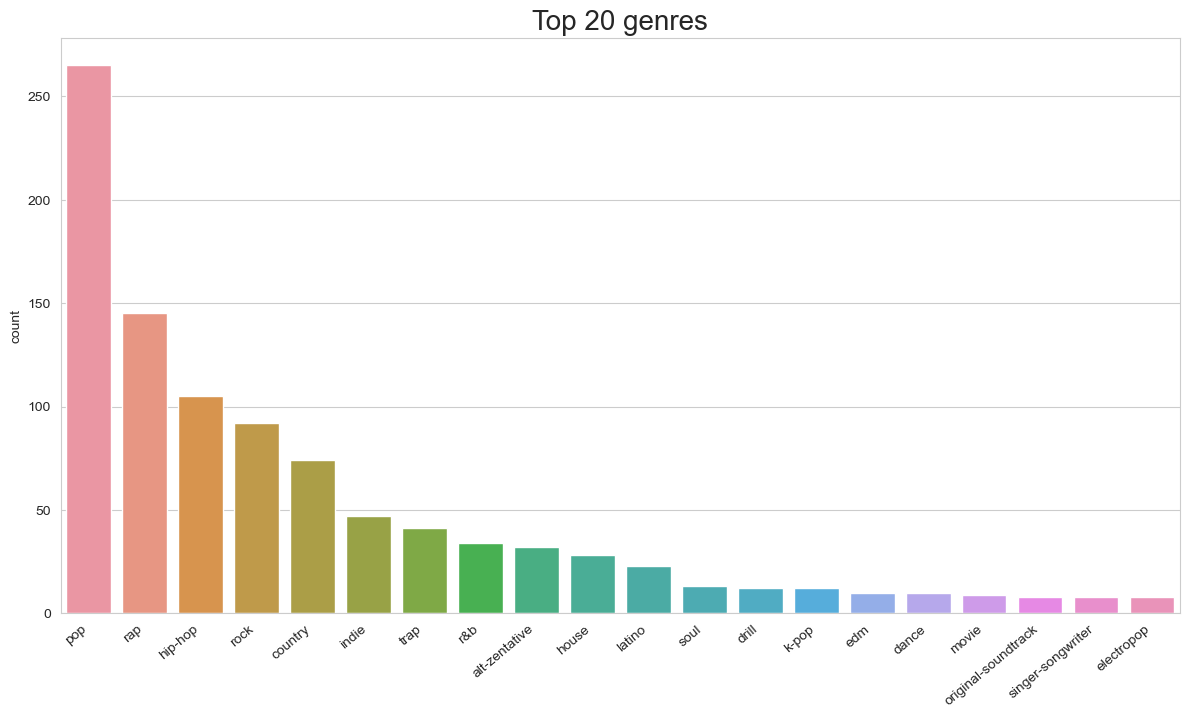

count     1147
unique     101
top        pop
freq       265
dtype: object

In [111]:
topgenres = make_hist_of_genres(dict_genres_updated, 'top genre', top_n= 20)
df_topgenres = pd.Series(topgenres)
df_topgenres.describe()

#### MORE BASIC STATS

....

#### Make network

## Remove "no genre???"

In [67]:
# Make function to format edges with weight and make network with genre as group
def make_network(dict_features_updated, dict_genres_updated, islimitedartists=True):
    """Function to make graph from dict of features. Edges will be features. The weight is features shared between artists."""
    G = nx.Graph()
    for artist in dict_features_updated.keys():
        artist_name = artist[0]
        artist_id = artist[1]
        G.add_node(artist_name, label=artist_id, group=dict_genres_updated[(artist_name,artist_id)]['top genre'])
        # exclude nodes removed since no genre
        
        res = Counter(dict_features_updated[artist])
        for key in res.keys():
            if key in dict_features_updated.keys() and islimitedartists:
                if G.has_edge(artist_name, key[0]):
                    G.get_edge_data(artist_name, key[0])['weight'] += res[key]
                else:
                    G.add_edge(artist_name, key[0], weight=res[key])
    return G


GGG = make_network(dict_features_updated, dict_genres_updated, islimitedartists=True)
# Remove nodes with top genre = 'no_genre'
#nodes_to_remove = [node for node in GGG.nodes() if dict_genres_updated[(node, GGG.nodes[node]['label'])]['top genre'] == 'no_genres']
#print(len(nodes_to_remove))
#GGG.remove_nodes_from(nodes_to_remove)


In [108]:
nw.visualize(GGG.copy() , plot_in_cell_below=True)

(None, None)

In [161]:
dict_degrees_per_genre = {}
top5_genres = ['pop', 'rap', 'hip-hop', 'rock', 'country']
for genre_type in top5_genres:
    dict_degrees_per_genre[genre_type] = np.array([GGG.degree(x, weight='weight') for x,y in GGG.nodes(data=True) if y['group']==genre_type])


In [162]:
#bins=np.histogram(np.hstack(([dict_degrees_per_genre[genre_type] for genre_type in top5_genres])), bins=20)[1] #get the bin edges
#bins

array([  0.  ,  30.15,  60.3 ,  90.45, 120.6 , 150.75, 180.9 , 211.05,
       241.2 , 271.35, 301.5 , 331.65, 361.8 , 391.95, 422.1 , 452.25,
       482.4 , 512.55, 542.7 , 572.85, 603.  ])

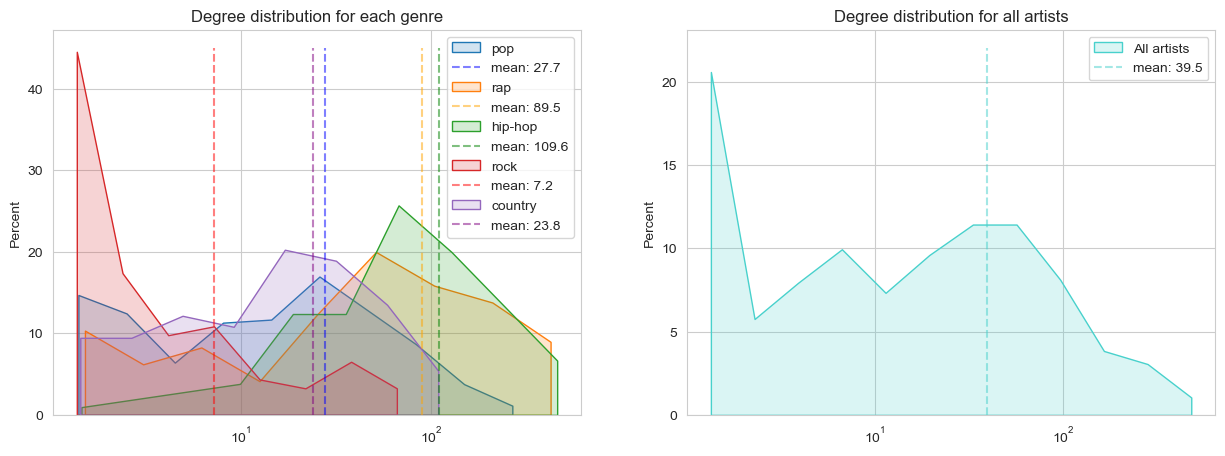

In [195]:
dict_degrees_per_genre = {}
top5_genres = ['pop', 'rap', 'hip-hop', 'rock', 'country']
for genre_type in top5_genres:
    dict_degrees_per_genre[genre_type] = np.array([GGG.degree(x, weight='weight') for x,y in GGG.nodes(data=True) if y['group']==genre_type])


list_all_degrees= np.array([v for k,v in GGG.degree(weight='weight')])


dict_colors = {'pop': 'blue', 'rap': 'orange', 'hip-hop': 'green', 'rock': 'red', 'country': 'purple'}
# Make two histograms of the degree distribution with subfigures
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
for genre_type in 'pop', 'rap', 'hip-hop', 'rock', 'country':
    sns.histplot(dict_degrees_per_genre[genre_type]+1,ax=ax1, label=genre_type, stat='percent', element='poly', fill=True, alpha=0.2, log_scale=True)
    ax1.vlines(np.mean(dict_degrees_per_genre[genre_type]), ymin= 0, ymax= 45, linestyles='dashed', label=f'mean: {np.mean(dict_degrees_per_genre[genre_type]):.1f}', colors=dict_colors[genre_type], alpha=0.5)

ax1.legend()
ax1.set_title('Degree distribution for each genre')
sns.histplot(list_all_degrees+1, ax=ax2, label='All artists', stat='percent', element='poly', fill=True, alpha=0.2, log_scale=True, color='mediumturquoise')
ax2.vlines(np.mean(list_all_degrees), ymin= 0, ymax= 22, linestyles='dashed', label=f'mean: {np.mean(list_all_degrees):.1f}', colors='mediumturquoise', alpha=0.5)

ax2.set_title('Degree distribution for all artists')
ax2.legend()

plt.show()


In [201]:
# Who has the most features shared with other artists?

li = [(k,v) for k,v in GGG.degree(weight='weight')]
pd.DataFrame(li, columns=['artist name', 'number of features']).sort_values(by='number of features', ascending=False).head(10)

,artist name,number of features
8,Future,603
32,Lil Wayne,569
14,Young Thug,549
97,Gucci Mane,501
132,French Montana,455
87,Rick Ross,389
34,Lil Durk,371
71,Juicy J,370
141,DJ Drama,367
140,Metro Boomin,365


#### Compare partitition genre - partition louvain - partition random (edge swap)

Helper function

In [227]:
def PartitioningGeneral(partion_dict):
    groups_dict = {key: [] for key in set(list(partion_dict.values()))}
    for instance in list(partion_dict.items()):
        groups_dict[instance[1]].append(instance[0])

    return list(groups_dict.values())


get the modularity and for the double edge:

In [228]:
# dict with artist name as key and top genre as value
dict_genres_partition = {k[0]: v['top genre'] for k, v in dict_genres_updated.items()}
#print(dict_genres_partition)
partition_genres = PartitioningGeneral(dict_genres_partition)
#print(partition_genres)
modularity_genre = nx.community.modularity(GGG, partition_genres)


In [229]:
GGG_copy = GGG.copy()
list_modu = []
for _ in tqdm(range(1000)):
    G_swapped = nx.double_edge_swap(GGG_copy, nswap=GGG.number_of_edges()*2, max_tries=1000000, seed=27)
    modu = nx.community.modularity(G_swapped, partition_genres)
    list_modu.append(modu)

  0%|          | 0/1000 [00:00<?, ?it/s]

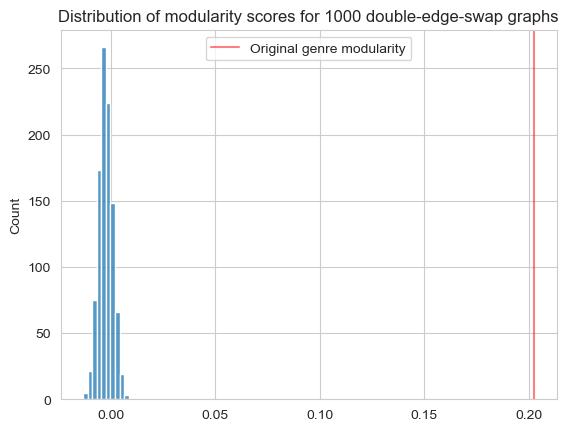

In [232]:
# plot hist of list_modu
sns.histplot(list_modu,bins=10)
plt.axvline(modularity_genre, c='red', label='Original genre modularity', alpha=0.5)
#plt.axvline(modularity_louvain, c='green', label='The Louvain partitions modularity')
plt.title('Distribution of modularity scores for 1000 double-edge-swap graphs')
plt.legend(loc=9)
plt.show()

What about louvain?:

In [130]:
dict_louvain_partition = community_louvain.best_partition(GGG)
partition_louvain = PartitioningGeneral(dict_louvain_partition)
modularity_louvain = nx.community.modularity(GGG, partition_louvain)



In [131]:
# Find modularity from G and partitions
print('',f'Genre modularity: {modularity_genre:.2f}', '\n', f'Louvain modularity: {modularity_louvain:.2f}')

 Genre modularity: 0.24 
 Louvain modularity: 0.56


#### Confusion matrix with most entries???

In [133]:
def GetMatrix(communities1, communities2):
    fulllist = []
    for l1 in communities2:
        appendlist = []
        for l2 in communities1:
            appendlist.append(len(list(set(l1) & set(l2))))
        fulllist.append(appendlist)
    np.array(fulllist)
    return np.array(fulllist)

In [134]:
def PartitioningGeneralIGEN(partion_dict):
    groups_dict = {key: [] for key in set(list(partion_dict.values()))}
    for instance in list(partion_dict.items()):
        groups_dict[instance[1]].append(instance[0])

    return groups_dict

In [171]:
# make matrix
M = GetMatrix(partition_genres,partition_louvain)

# Get top 5 genres
largest_genres_idx = M.sum(axis=0).argsort()[-8:][::-1]
largest_genre_names = [list(PartitioningGeneralIGEN(dict_genres_partition).keys())[i] for i in largest_genres_idx]

# Get top 5 louvain partitions
largest_louvain_idx = M.sum(axis=1).argsort()[-8:][::-1]
largest_louvain_names = [list(PartitioningGeneralIGEN(dict_louvain_partition).keys())[i] for i in largest_louvain_idx]

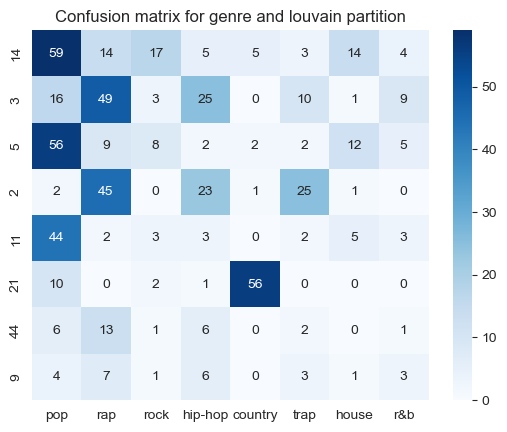

In [173]:
sns.heatmap(M[largest_louvain_idx,:][:,largest_genres_idx], annot=True, cmap='Blues',xticklabels=largest_genre_names, yticklabels=largest_louvain_names)
plt.title('Confusion matrix for genre and louvain partition')
plt.show()

#### Maybe average distance between communities (which genres work the most together)

## Text analysis - Top songs 

In [10]:
response2 = get_songs_by_artist(token, id1)

In [13]:
for song in response2['tracks']: #[0]#['artists']
    print(song['name'])

As It Was
Watermelon Sugar
Late Night Talking
Adore You
Sign of the Times
Falling
Matilda
Music For a Sushi Restaurant
Satellite
Golden


In [33]:
# read pickle file
with open('dict_features01.pickle', 'rb') as handle:
    dict_features1 = pickle.load(handle)

with open('dict_features02.pickle', 'rb') as handle:
    dict_features2 = pickle.load(handle)

with open('dict_features03.pickle', 'rb') as handle:
    dict_features3 = pickle.load(handle)

In [36]:
dict_features_all = {**dict_features1, **dict_features2, **dict_features3}
len(dict_features_all)

1250

In [37]:
with open('dict_featuresALL.pickle', 'wb') as handle:
    pickle.dump(dict_features_all, handle)

In [26]:
np.where(unique_artists == 'Nat King Cole Trio')

(array([1113]),)

In [28]:
unique_artists[1114:]

array(['Johnny Mathis', 'grandson', 'The Strokes', 'Bee Gees',
       'New Community Church', "Destiny's Child", 'Jameson Rodgers',
       'Passion Pit', 'HAIM', 'Dj Ozuna', 'Thirty Seconds To Mars',
       'Kim Cesarion', 'ODESZA', 'Cobra Starship', 'Michael Ray',
       'Wizkid', 'Soundgarden', 'Coleman Hell', 'iSHi',
       'Theophilus London', 'Chad Focus', 'David Bowie', 'Roy Woods',
       'Jaymes Reunion', 'Foster The People', 'Jennifer Lopez',
       'Alicia Keys', 'SNBRN', 'Shaun Reynolds', 'Radiohead', 'JoJo',
       'TWENTY88', 'Kalin and Myles', 'AronChupa', 'Niykee Heaton',
       'Chedda Da Connect', 'The Low Down', 'Miike Snow', 'New Politics',
       'Florence + The Machine', 'Beck', 'AFROJACK', 'Ludacris', 'Priory',
       'Fences', 'Seth MacFarlane', 'Nico Segal', 'Ace Hood',
       'Mary Lambert', 'Phoebe Ryan', 'LÃ\x89ON', 'Bankroll Fresh',
       'Alabama Shakes', 'Ryan Adams', 'Snoop Dogg',
       'Edward Sharpe & The Magnetic Zeros', 'The-Dream', 'Moxie Raia',
  

# The actual delievery

## Motovation


What is your dataset?

Why did you choose this/these particular dataset(s)?

What was your goal for the end user’s experience?

## Basic stats. Let’s understand the dataset better


Write about your choices in data cleaning and preprocessing

    - Is the list actually top artists
    - Some songs are included multiple times (because remix' etc. )
    - Determination of genre
    

Write a short section that discusses the dataset stats (here you can recycle the work you did for Project Assignment A)

http://networksciencebook.com/chapter/3#clustering-3-9??? cluster coefficient?

## Tools, theory and analysis. Describe the process of theory to insight


Talk about how you’ve worked with text, including regular expressions, unicode, etc.

Describe which network science tools and data analysis strategies you’ve used, how those network science measures work, and why the tools you’ve chosen are right for the problem you’re solving.

How did you use the tools to understand your dataset?

## Discussion. Think critically about your creation



What went well?

What is still missing? What could be improved? Why?